In [ ]:
#Importação das bibliotecas necessárias para construir o modelo.

import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from  sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
start = '2014-01-01'
end = '2020-01-01'

In [ ]:
df = web.DataReader('^BVSP',data_source='yahoo',start=start,end=end)
df.rename(columns={'Close': 'preco_fechamento'},inplace = True)
df = df.drop(columns=['High','Low','Open','Volume','Adj Close'])
df.head()

,preco_fechamento
Date,
2014-01-02,50341.0
2014-01-03,50981.0
2014-01-06,50974.0
2014-01-07,50430.0
2014-01-08,50577.0


In [ ]:
# Pegando o numero de linhas e colunas no dataset
df.shape

(1483, 1)

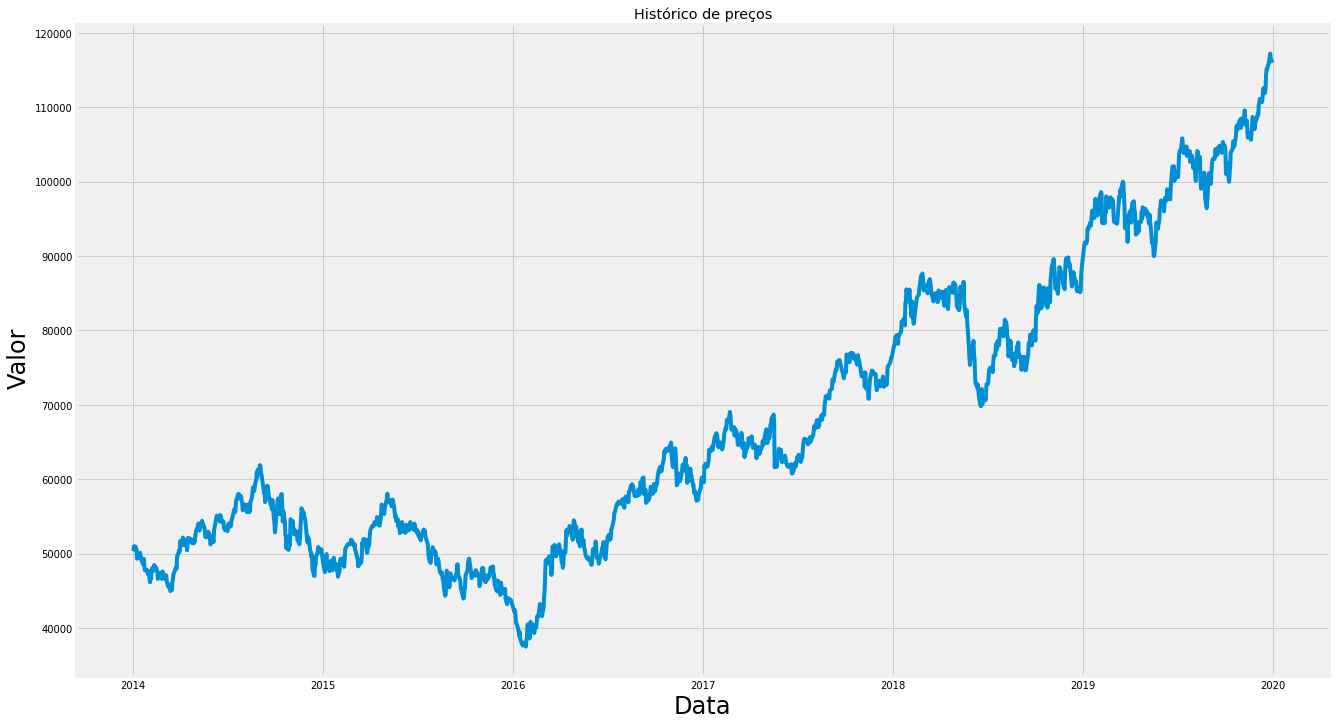

In [ ]:
#Visualizando o histórico de preço de fechamento

plt.figure(figsize=(20,12))
plt.title('Histórico de preços')
plt.plot(df['preco_fechamento'])
plt.xlabel('Data',fontsize = 24)
plt.ylabel('Valor  ', fontsize=24)
plt.show()

In [ ]:
# Criando um novo dataframe usando somente a coluna Closing(preco_de_fechamento)
data = df.filter(['preco_fechamento'])
# Convertendo o data frame para um np array
dataset = data.values
# Obtendo o número de linhas para treinar o modelo
training_data_len = math.ceil(len(dataset) * .8)

training_data_len 

1187

In [ ]:
# Dimensionando os dados
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data


array([[0.1611422 ],
       [0.16917171],
       [0.16908388],
       ...,
       [1.        ],
       [0.99160665],
       [0.98445537]])

In [ ]:
# Criando o dataset de treinamento

train_data = scaled_data[0:training_data_len,:]

x_train = []
y_train = []


for i in range (60,len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])

  if i<=60:
    print(x_train)
    print(y_train)
    print('\n')


[array([0.1611422 , 0.16917171, 0.16908388, 0.1622588 , 0.16410308,
       0.14835771, 0.15304996, 0.14967506, 0.15313778, 0.15818132,
       0.15304996, 0.14660126, 0.1406544 , 0.13857175, 0.1480817 ,
       0.13579906, 0.12909944, 0.12802048, 0.12977693, 0.12621384,
       0.1222869 , 0.12724262, 0.10853637, 0.11877399, 0.11450832,
       0.12848468, 0.13270017, 0.12814594, 0.13758061, 0.13449427,
       0.12942564, 0.13429353, 0.12645221, 0.11420721, 0.12112012,
       0.12285148, 0.12399317, 0.12415627, 0.11566256, 0.11419467,
       0.12684114, 0.12040499, 0.1140692 , 0.12039244, 0.1097408 ,
       0.10082052, 0.10289062, 0.10494818, 0.09970391, 0.09370687,
       0.09561388, 0.10856146, 0.11379319, 0.12271347, 0.12400572,
       0.13168394, 0.13403006, 0.13134519, 0.1524352 , 0.15395328])]
[0.16207060948987523]




In [ ]:
# Convertendo em np arrays

x_train,y_train = np.array(x_train), np.array(y_train)

In [ ]:
# alterando as dados para 3 dimensões
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape


(1127, 60, 1)

In [ ]:
# Criando o modelo de LSTM Long Short Term Memory (LSTM)

model = Sequential()

model.add(LSTM(50,return_sequences=True,input_shape = (x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
# compilando o modelo ...
model.compile(optimizer='adam',loss='mean_squared_error')


In [ ]:
#Treinando o modelo ...
model.fit(x_train,y_train,batch_size=1,epochs=1)

1127/1127 [==============================] - 43s 22ms/step - loss: 0.0034


In [ ]:
# criando o dataset de teste 

test_data = scaled_data[training_data_len - 60:, :]

#criando os datasets x e y
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])


In [ ]:
# Convertendo os dados para um np array
x_test = np.array(x_test)


In [ ]:
# fazendo o rashape dos dados
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [ ]:
# obtendo os valores de previsão de preço

preco_previsao = model.predict(x_test)
preco_previsao = scaler.inverse_transform(preco_previsao)

In [ ]:
# Root mean squared error (RMSE) 
rmse = np.sqrt(np.mean(preco_previsao - y_test) **2 )
rmse

833.3846072635135

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


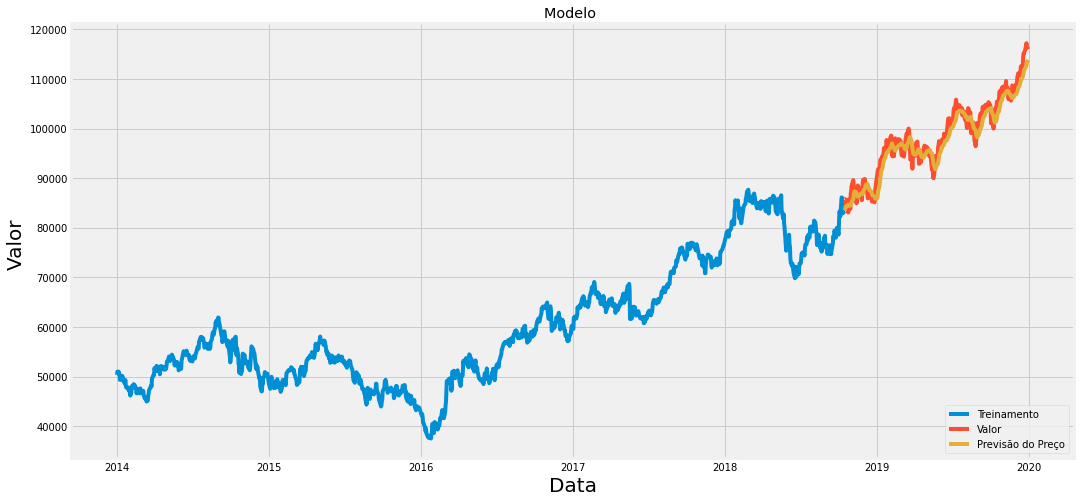

In [ ]:
# plottando os dados
train = data[:training_data_len]
valid = data[training_data_len:]
valid['preco_previsao'] = preco_previsao

#Visualizando os dados

plt.figure(figsize=(16,8))
plt.title('Modelo ')
plt.xlabel('Data',fontsize=20)
plt.ylabel('Valor ' , fontsize = 20)
plt.plot(train['preco_fechamento'])
plt.plot(valid[['preco_fechamento','preco_previsao']])
plt.legend(['Treinamento','Valor','Previsão do Preço'], loc='lower right')
plt.show()

In [ ]:
 # Mostrando exemplos de valores e a previsão dos preços
 valid

,preco_fechamento,preco_previsao
Date,,
2018-05-24,80122.0,83204.382812
2018-05-25,78898.0,82421.890625
2018-05-28,75356.0,81521.929688
2018-05-29,76072.0,80120.835938
2018-05-30,76754.0,78853.539062
...,...,...
2019-12-20,115121.0,114826.664062
2019-12-23,115863.0,115466.742188
2019-12-26,117203.0,116110.804688
